In [17]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import json
from collections import Counter
import pickle
import random

import math
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

from openai import OpenAI
from anthropic import Anthropic


In [ ]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

os.environ['WANDB_API_KEY'] = os.getenv('WANDB_API_KEY', 'your-wandb-key')

In [4]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [22]:
from items import Item
from loaders import ItemLoader
from testing import Tester

In [18]:
openai = OpenAI()
claude = Anthropic()

In [6]:
%matplotlib inline

In [7]:
# Specify and load huggingface dataset
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [8]:
print(f"Number of Appliances: {len(dataset):,}")
datapoint = dataset[4]
print(f"Title: {datapoint['title']}\n")
print(f"Description: {datapoint['description']}\n")
print(f"Features: {datapoint['features']}\n")
print(f"Details: {datapoint['details']}\n")
print(f"Price: {datapoint['price']}\n")

Number of Appliances: 94,327
Title: Whirlpool W10918546 Igniter

Description: ['Whirlpool Igniter']

Features: ['This is a Genuine OEM Replacement Part.']

Details: {"Manufacturer": "Whirlpool", "Part Number": "W10918546", "Item Weight": "1 pounds", "Product Dimensions": "1 x 1 x 1 inches", "Item model number": "W10918546", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Warranty Description": "This is a Genuine OEM Replacement Part.", "Best Sellers Rank": {"Tools & Home Improvement": 655322, "Parts & Accessories": 93370}, "Date First Available": "April 19, 2019"}

Price: 25.07



In [79]:
##################### GET CATEGORIES #####################
def get_categories_data(dataset):
    category_counter = Counter()
    categories_list = []
    for datapoint in dataset:
        try:
            category = datapoint['details']
            category_as_json = json.loads(category)
            keys = category_as_json.keys()
            for key in keys:
                if key == "Best Sellers Rank":
                    item_category = list(category_as_json[key].keys())
                    if item_category and isinstance(item_category, list):
                        for cat in item_category:
                            category_counter[cat] += 1
                        categories_list.append(item_category)
        except KeyError:
            pass

    return category_counter, categories_list


In [80]:
category_counter, categories_list_per_item= get_categories_data(dataset)

In [81]:
category_counter.elements

<bound method Counter.elements of Counter({'Tools & Home Improvement': 47930, 'Dryer Replacement Parts': 11164, 'Parts & Accessories': 10593, 'Appliances': 6005, 'In-Refrigerator Water Filters': 4025, 'Home & Kitchen': 2240, 'Washer Parts & Accessories': 2100, 'Reusable Coffee Filters': 2024, 'Range Accessories': 1510, 'Range Replacement Knobs': 1457, 'Paper & Plastic Household Supplies': 1439, 'Health & Household': 1428, 'Cooktop Parts & Accessories': 1302, 'Clothes Washer Replacement Drain Pumps': 1272, 'Disposable Coffee Filters': 1153, 'Range Hoods': 1126, 'Dishwasher Replacement Hoses': 1124, 'Refrigerators': 1031, 'Refrigerator Egg Trays': 923, 'Refrigerator Replacement Handles': 898, 'Portable Clothes Washing Machines': 890, 'Humidifier Replacement Wicks': 875, 'Refrigerator Replacement Shelves': 870, 'Dishwasher Replacement Baskets': 815, 'Clothes Dryer Replacement Vents': 792, 'Refrigerator Replacement Bins': 740, 'Range Hood Filters': 740, 'Refrigerator Replacement Motors': 7

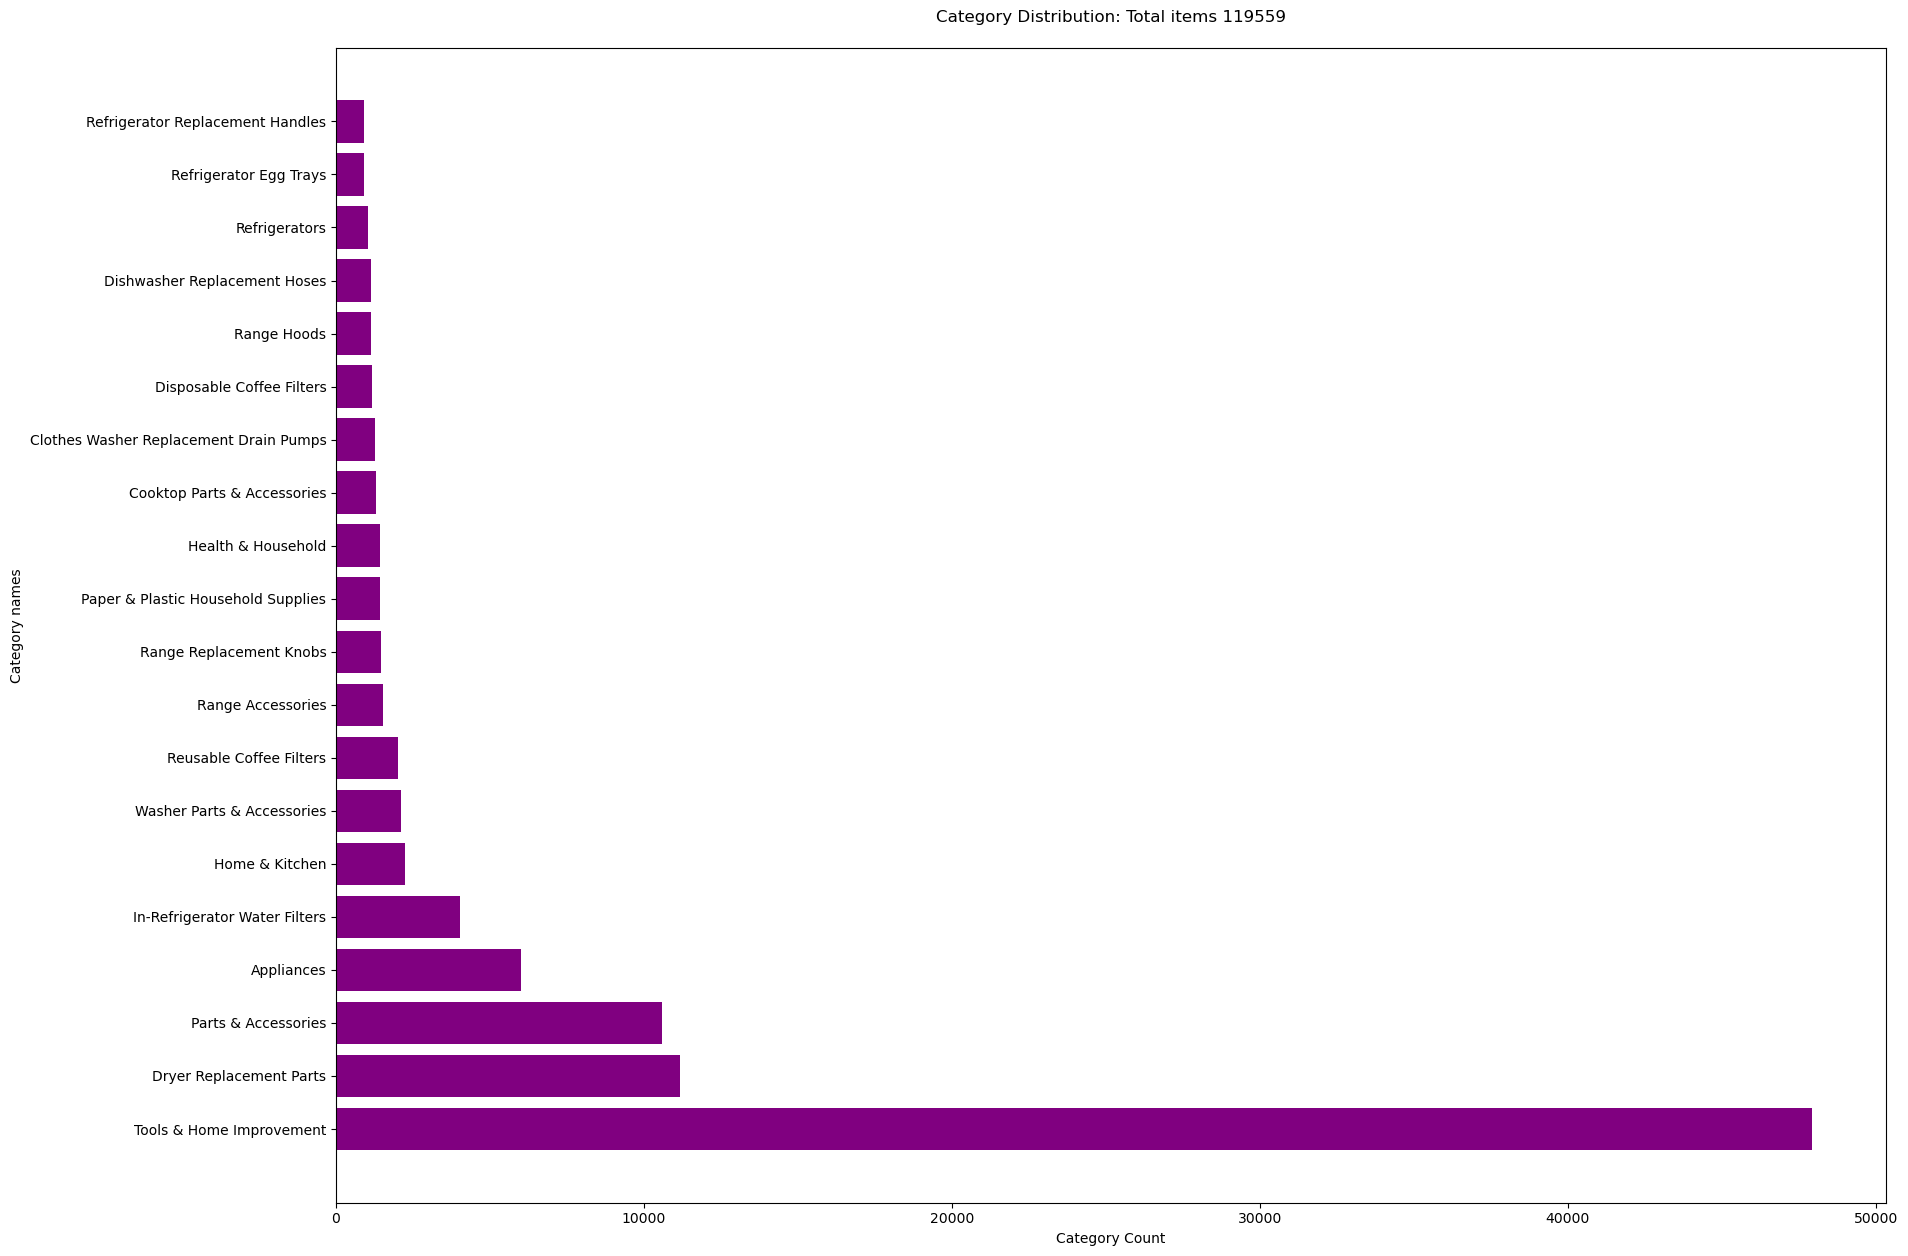

In [82]:
display_counter = category_counter.most_common(20)
plt.figure(figsize=(20, 15))
plt.title(f"Category Distribution: Total items {sum(category_counter.values())}\n")
plt.xlabel('Category Count')
plt.ylabel('Category names')
plt.barh([item[0] for item in display_counter], [item[1] for item in display_counter], color="purple")
plt.show()

In [78]:
no_empty_categories = [item for item in categories_list_per_item if item]

print(f"There are {len(no_empty_categories):,} with categories which is {len(no_empty_categories)/len(dataset)*100:,.1f}%")

There are 58,280 with categories which is 61.8%


In [66]:
##################### GET PRICES #####################
prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [65]:
def get_prices(dataset):
    prices = []
    len_prices = []
    for datapoint in dataset:
        try:
            price = float(datapoint["price"])
            if price > 0:
                prices.append(price)
                contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
                len_prices.append(len(contents))
        except ValueError as e:
            pass
    return prices, len_prices

In [ ]:
prices, len_prices = get_prices(dataset)
print(prices[:10])
print(len_prices[:10])

In [ ]:
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(len_prices)/len(len_prices):,.0f} and highest {max(len_prices):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(len_prices, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [ ]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

In [ ]:
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

In [85]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]

In [163]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Completed Appliances with 28,625 datapoints in 1.0 mins


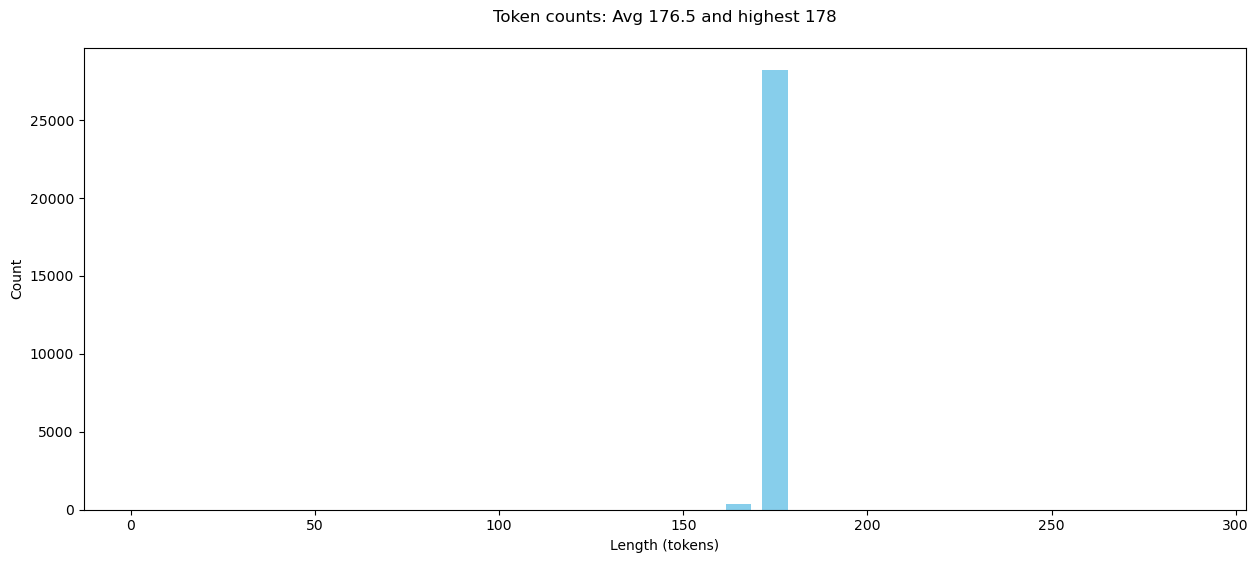

In [164]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

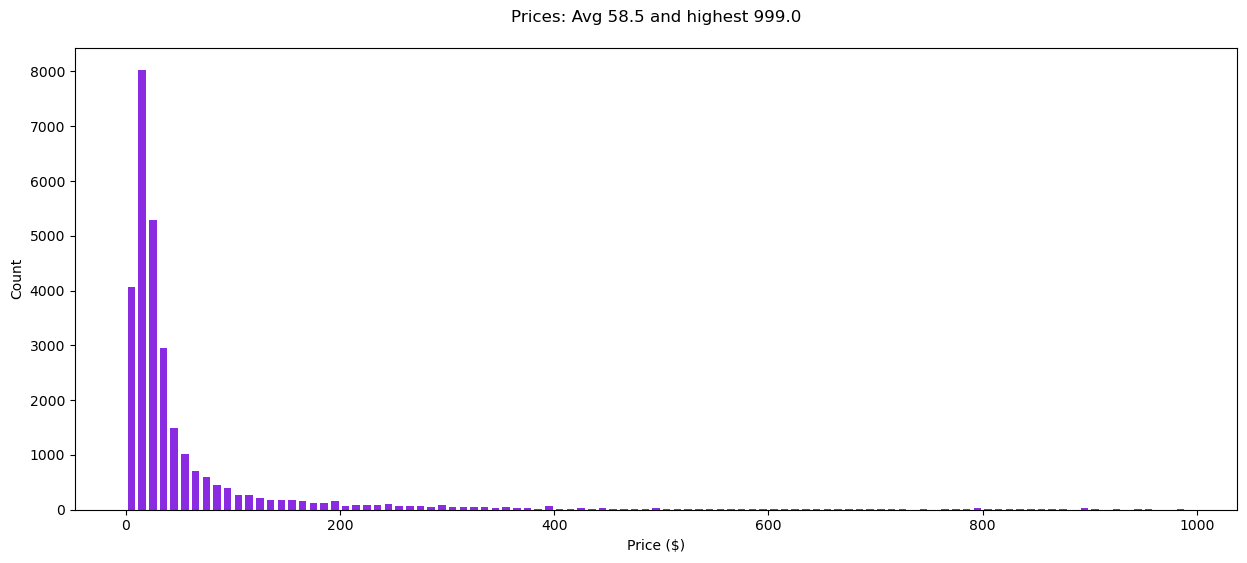

In [165]:
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

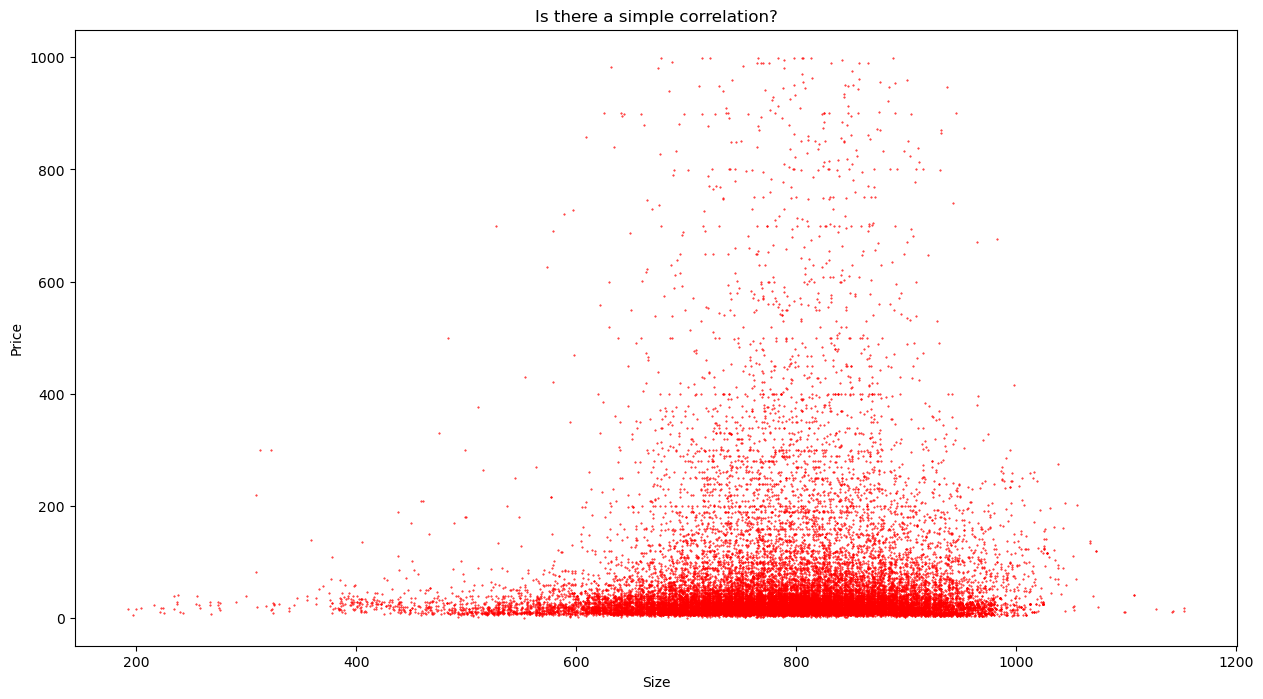

In [166]:
sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [167]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [168]:
report(sample[0])

How much does this cost to the nearest dollar?

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces
PARTS NUMBER The dishwasher top rack wheels and stud assembly Kit （4 pcs） SCOPE OF APPLICATION The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud REPLACES PART FIXES SYMPTOMS Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure QUALITY WARRANTY The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund Brand Name AMI PARTS, Model

Price is $9.00
[50, 11, 5008, 271, 7117, 374, 400, 24, 13, 410]
['S', ',', ' Model', '\n\n', 'Price', ' is', ' $', '9', '.', '00']


In [169]:
random.seed(42)
random.shuffle(sample)
train = sample[:26_000]
test = sample[26_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 26,000 items and test set of 1,000 items


In [170]:
# Observe how tokens are handles when 3 digits ($100 or more)
max_item = [item for item in items if item.price > 99]
report(max_item[0])

How much does this cost to the nearest dollar?

Panda Small Portable Washing Machine, 1.54 cu.ft, 8 Wash Programs, Top Load Clothes Washer, Gray
It is a space-saving design which makes your laundry easy and simple. It is perfect for Apartment, RV, Vacation Home, Dorm, and second washer for your house. Lager size 1.54 cu.ft capacity, timeless design, portable and lightweight to carry around, regular 3 prongs 110 Voltage which can be plugged anywhere. Electronic controls with LED display. 8 washing programs and 4 water levels, Stainless steel drum is durable and resists rust and chipping. Connect the washer directly to your faucet with the included quick connect adapter kit and hoses. Brand Name Panda, Model Info Weight 55 Pounds, Dimensions 19.5\ D x

Price is $261.00
[59, 423, 865, 271, 7117, 374, 400, 15602, 13, 410]
['\\', ' D', ' x', '\n\n', 'Price', ' is', ' $', '261', '.', '00']


In [171]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [172]:
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [173]:
DATASET_NAME = "david-rod/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/26 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/david-rod/lite-data/commit/36cd84977b599ba5393a65945a06d7653303db6d', commit_message='Upload dataset', commit_description='', oid='36cd84977b599ba5393a65945a06d7653303db6d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/david-rod/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='david-rod/lite-data'), pr_revision=None, pr_num=None)

In [174]:

with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)

In [175]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [176]:
print(train[0].price)

11.99


In [177]:
print(train[0].test_prompt())

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $


In [14]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error/truth < 0.1:
            return "green"
        elif error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} Error_Perc={error/truth:.2%}% SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

In [179]:
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [180]:
def random_pricer(item):
    return random.randrange(1,1000)

In [181]:
random.seed(42)
print(random.randrange(1,1000))
print(random.randrange(1,1000))
print(random.randrange(1,1000))

655
115
26


1: Guess: $655.00 Truth: $48.23 Error: $606.77 Error_Perc=1258.08%% SLE: 6.71 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $115.00 Truth: $29.60 Error: $85.40 Error_Perc=288.51%% SLE: 1.78 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $26.00 Truth: $35.99 Error: $9.99 Error_Perc=27.76%% SLE: 0.10 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $760.00 Truth: $9.27 Error: $750.73 Error_Perc=8098.49%% SLE: 18.54 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $282.00 Truth: $21.99 Error: $260.01 Error_Perc=1182.40%% SLE: 6.30 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $251.00 Truth: $33.71 Error: $217.29 Error_Perc=644.59%% SLE: 3.93 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $229.00 Truth: $18.99 Error: $210.01 Error_Perc=1105.90%% SLE: 5.97 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $143.00 Truth: $29.99 Error: $113.01 Error_Perc=376.83%% SLE: 2.36 Item: 5pcs Upgraded Wb03x24818 Gas 

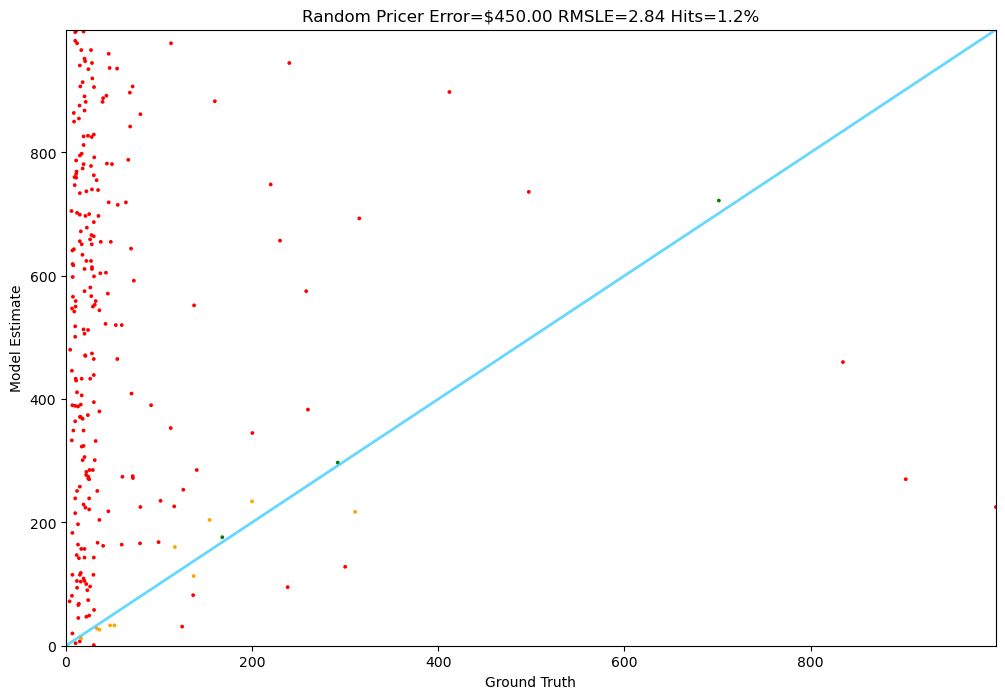

In [182]:
random.seed(42)

Tester.test(random_pricer)

In [183]:
training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $58.60 Truth: $48.23 Error: $10.37 Error_Perc=21.51%% SLE: 0.04 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $58.60 Truth: $29.60 Error: $29.00 Error_Perc=97.99%% SLE: 0.44 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $58.60 Truth: $35.99 Error: $22.61 Error_Perc=62.83%% SLE: 0.23 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $58.60 Truth: $9.27 Error: $49.33 Error_Perc=532.19%% SLE: 3.09 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $58.60 Truth: $21.99 Error: $36.61 Error_Perc=166.50%% SLE: 0.91 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $58.60 Truth: $33.71 Error: $24.89 Error_Perc=73.85%% SLE: 0.29 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $58.60 Truth: $18.99 Error: $39.61 Error_Perc=208.60%% SLE: 1.19 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $58.60 Truth: $29.99 Error: $28.61 Error_Perc=95.41%% SLE: 0.43 Item: 5pcs Upgraded Wb03x24818 Gas Stove Knobs...
9: Gue

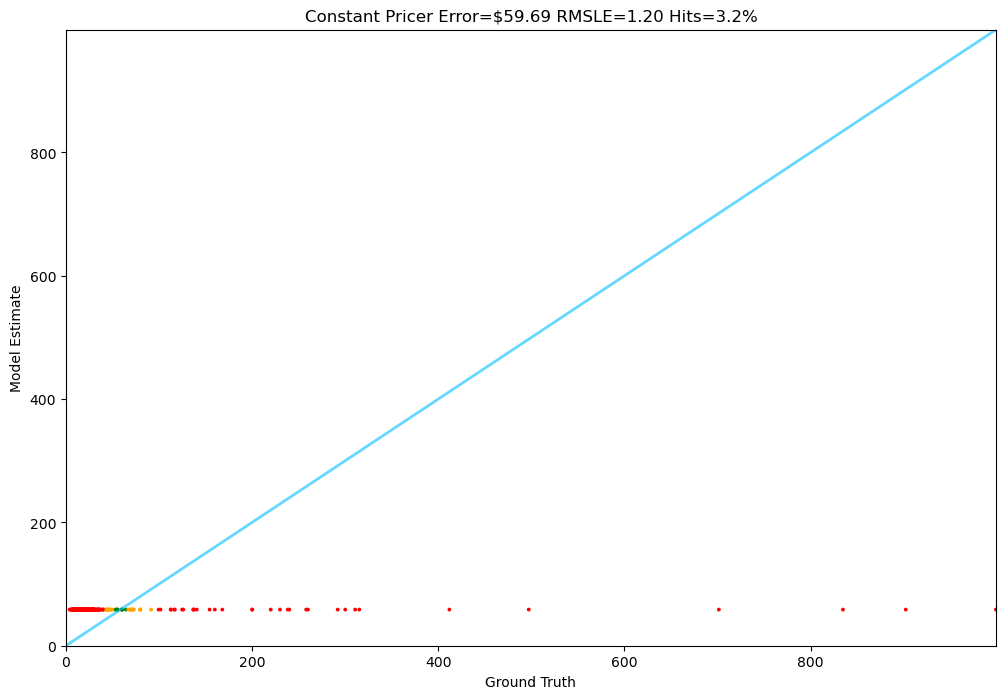

In [184]:
Tester.test(constant_pricer)

In [185]:
train[0].details

'{"Manufacturer": "Saffire", "Part Number": "WB31T10010 WB31T10011", "Item Weight": "1.17 pounds", "Product Dimensions": "10 x 10 x 2.5 inches", "Country of Origin": "China", "Item model number": "1854&1857", "Included Components": "Drip pans", "Batteries Included?": "No", "Batteries Required?": "No", "Warranty Description": "100% MONEYBACK GUARANTEE: We offer 100% money back guarantee with no questions asked. This great product also comes with 10-year warranty for quality related issues. Purchase with confidence and enjoy our risk-free offer", "Best Sellers Rank": {"Tools & Home Improvement": 162062, "Range Replacement Drip Pans": 144}, "Date First Available": "October 19, 2022"}'

In [186]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one
train[0].features.keys()

dict_keys(['Manufacturer', 'Part Number', 'Item Weight', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Included Components', 'Batteries Included?', 'Batteries Required?', 'Warranty Description', 'Best Sellers Rank', 'Date First Available'])

In [187]:
feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 24251),
 ('Best Sellers Rank', 22902),
 ('Item Weight', 20732),
 ('Item model number', 18200),
 ('Manufacturer', 17604),
 ('Part Number', 17232),
 ('Batteries Required?', 15423),
 ('Brand', 14449),
 ('Product Dimensions', 14276),
 ('Batteries Included?', 12649),
 ('Is Discontinued By Manufacturer', 9677),
 ('Color', 9294),
 ('Material', 9237),
 ('Package Dimensions', 8046),
 ('Brand Name', 6411),
 ('Included Components', 6201),
 ('Item Package Quantity', 5738),
 ('Country of Origin', 5287),
 ('Model Info', 4832),
 ('Special Features', 3403),
 ('Shape', 3281),
 ('Number of Pieces', 3255),
 ('Special Feature', 3253),
 ('Material Type', 2871),
 ('Style', 2793),
 ('Voltage', 2589),
 ('Size', 2513),
 ('Item Dimensions LxWxH', 2442),
 ('Unit Count', 2169),
 ('External Testing Certification', 2034),
 ('Compatible Devices', 1957),
 ('Finish Type', 1951),
 ('Warranty Description', 1850),
 ('Capacity', 1797),
 ('Number of Items', 1453),
 ('Power Source', 1398),
 ('Durat

In [188]:
def get_brands(item):
    return item.features.get("Brand", "Unknown")

In [189]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]
average_weight = sum(weights)/len(weights)

def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [ ]:
def get_product_dimensions(item):
    dims_str = item.features.get("Product Dimensions", "Unknown")
    if dims_str == "Unknown" or not dims_str:
        return None

    try:
        # Extract numbers from string like "10 x 10 x 2.5 inches"
        import re
        numbers = re.findall(r'\d+\.?\d*', dims_str)
        if len(numbers) >= 3:
            length, width, height = float(numbers[0]), float(numbers[1]), float(numbers[2])
            volume = length * width * height
            return volume
        elif len(numbers) == 2:
            # For 2D items, assume height = 1
            length, width = float(numbers[0]), float(numbers[1])
            return length * width
    except (ValueError, IndexError):
        pass

    return None

volumes = [get_product_dimensions(item) for item in train]
volumes = [v for v in volumes if v is not None]
average_volume = sum(volumes) / len(volumes) if volumes else 1.0

def get_product_dimensions_with_default(item):
    volume = get_product_dimensions(item)
    return volume if volume is not None else average_volume

In [233]:
def get_text_length(item):
    return len(item.test_prompt())

In [234]:
def get_category(item):
    if item.features.get("Best Sellers Rank"):
        categories = list(item.features.get("Best Sellers Rank").keys())
        for category in categories:
            if "Appliances" in category:
                return category

In [235]:
brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

brands.most_common(40)

[('GE', 499),
 ('Upstart Battery', 497),
 ('Whirlpool', 486),
 ('Frigidaire', 425),
 ('Supplying Demand', 294),
 ('UpStart Components', 203),
 ('SAMSUNG', 189),
 ('BlueStars', 159),
 ('Supco', 139),
 ('ICEPURE', 137),
 ('LG', 124),
 ('Broan-NuTone', 100),
 ('Lifetime Appliance Parts', 92),
 ('AMI PARTS', 92),
 ('PartsBroz', 89),
 ('Waterdrop', 77),
 ('Swift Green Filters', 74),
 ('Beaquicy', 74),
 ('Generic', 69),
 ('Air Filter Factory', 68),
 ('Nostalgic Warehouse', 68),
 ('Electrolux', 65),
 ('Aqua Fresh', 59),
 ('PUREPLUS', 59),
 ('Wowfeel', 59),
 ('Melitta', 58),
 ('Empava', 57),
 ('HQRP', 57),
 ('Edgewater Parts', 51),
 ('AQUA CREST', 50),
 ('Tier1', 49),
 ('BRBHOM', 48),
 ('COSTWAY', 48),
 ('Denali Pure', 47),
 ('BUNN', 47),
 ('Refresh', 47),
 ('Seentech', 45),
 ('GOLDEN ICEPURE', 45),
 ('EXCELPURE', 44),
 ('Range Kleen', 43)]

In [263]:
TOP_APPLIANCE_BRANDS = [brand for brand, _ in brands.most_common(50)]
def is_top_appliance_brand(item):
    brand = item.features.get("Brand")
    # Handle both None and string "None" as no brand
    if not brand or brand == "None":
        return False
    return brand in TOP_APPLIANCE_BRANDS

In [270]:
# Items in dict indicate features considered for price impact
def get_features(item):
    return {
        "category": 1 if get_category(item) else 0,
        "weight": get_weight_with_default(item),
        "text_length": get_text_length(item),
        "is_top_appliance_brand": 1 if is_top_appliance_brand(item) else 0
    }

In [271]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [274]:
train_df.head()

,category,weight,text_length,is_top_appliance_brand,price
0,0,1.170000,703,0,11.99
1,1,55.000000,771,0,261.27
2,0,3.690000,671,0,84.99
3,0,0.437500,651,0,15.14
4,0,3.932445,861,0,21.99


In [275]:
np.random.seed(42)

# Separate features and target
feature_columns = ['category', 'weight', 'text_length', 'is_top_appliance_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

category: 101.83425944334273
weight: 4.179912532501017
text_length: 0.03197583969214653
is_top_appliance_brand: 4.044221468595939
Intercept: 8.738137416047145
Mean Squared Error: 6456.1580272201745
R-squared Score: 0.5740274473297236


In [277]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $47.54 Truth: $48.23 Error: $0.69 Error_Perc=1.43%% SLE: 0.00 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $133.61 Truth: $29.60 Error: $104.01 Error_Perc=351.39%% SLE: 2.19 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $48.76 Truth: $35.99 Error: $12.77 Error_Perc=35.47%% SLE: 0.09 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $36.19 Truth: $9.27 Error: $26.92 Error_Perc=290.45%% SLE: 1.66 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $50.82 Truth: $21.99 Error: $28.83 Error_Perc=131.11%% SLE: 0.66 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $49.15 Truth: $33.71 Error: $15.44 Error_Perc=45.81%% SLE: 0.14 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $33.61 Truth: $18.99 Error: $14.62 Error_Perc=76.99%% SLE: 0.30 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $34.83 Truth: $29.99 Error: $4.84 Error_Perc=16.12%% SLE: 0.02 Item: 5pcs Upgraded Wb03x24818 Gas Stove Knobs...
9: Gues

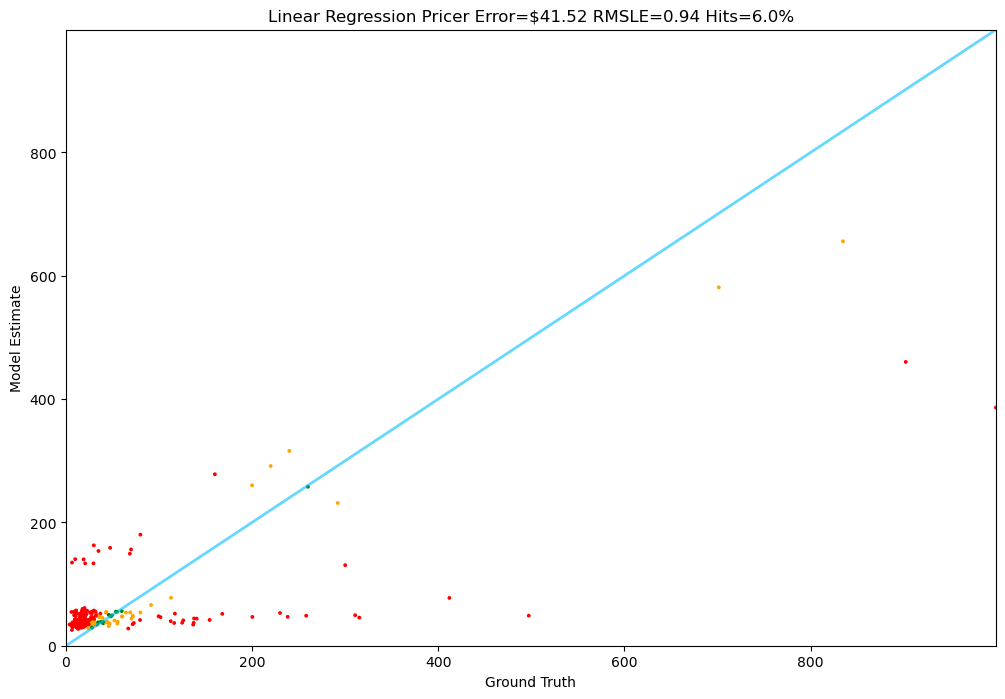

In [278]:
Tester.test(linear_regression_pricer)

In [279]:
#### BAG OF WORDS ####

# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [282]:
np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [283]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $29.40 Truth: $48.23 Error: $18.83 Error_Perc=39.05%% SLE: 0.23 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $190.86 Truth: $29.60 Error: $161.26 Error_Perc=544.81%% SLE: 3.37 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $78.66 Truth: $35.99 Error: $42.67 Error_Perc=118.56%% SLE: 0.59 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $2.45 Truth: $9.27 Error: $6.82 Error_Perc=73.53%% SLE: 1.19 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $0.00 Truth: $21.99 Error: $21.99 Error_Perc=100.00%% SLE: 9.83 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $29.17 Truth: $33.71 Error: $4.54 Error_Perc=13.45%% SLE: 0.02 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $0.00 Truth: $18.99 Error: $18.99 Error_Perc=100.00%% SLE: 8.97 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $3.13 Truth: $29.99 Error: $26.86 Error_Perc=89.56%% SLE: 4.06 Item: 5pcs Upgraded Wb03x24818 Gas Stove Knobs...
9: Guess:

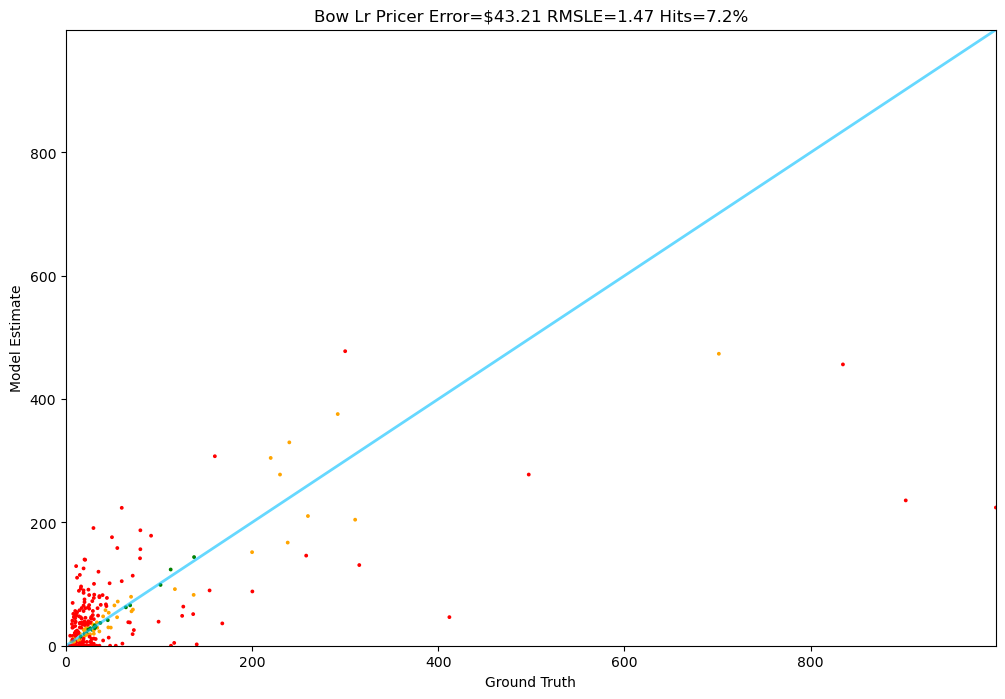

In [284]:
Tester.test(bow_lr_pricer)

In [6]:
with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [8]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nLG Genuine OEM Pulsator Plate/Washplate Assembly for LG Washing Machines\nThis high quality OEM LG Noise Filter Assembly is manufactured to exact specifications with durable materials and will fit a variety of LG Washing Machine models. Offering security and reliability that your LG Washing Machine will function correctly and will not be damaged by fluctuating electrical currents. The LG Noise Filter cleans the electricity from the electrical power supply to prevent control board damage from power surges by filter the electricity as it passes through the Noise Filter. Please be aware that the electrical power should be disconnected from the Washing Machine prior to making replacement on the appliance. Compatible Models This LG is a genuine OEM (Original Equipment Manufacturer) part manufactured to exact specifications R

In [9]:
import re


def get_price(string_value):
    s = string_value.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [10]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [20]:
def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [12]:
test[0].price


48.23

1: Guess: $30.00 Truth: $48.23 Error: $18.23 SLE: 0.21 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $35.99 Truth: $29.60 Error: $6.39 SLE: 0.04 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $32.99 Truth: $35.99 Error: $3.00 SLE: 0.01 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $14.99 Truth: $9.27 Error: $5.72 SLE: 0.20 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $15.99 Truth: $21.99 Error: $6.00 SLE: 0.09 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $65.99 Truth: $33.71 Error: $32.28 SLE: 0.43 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $23.99 Truth: $18.99 Error: $5.00 SLE: 0.05 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $24.99 Truth: $29.99 Error: $5.00 SLE: 0.03 Item: 5pcs Upgraded Wb03x24818 Gas Stove Knobs...
9: Guess: $15.99 Truth: $33.00 Error: $17.01 SLE: 0.48 Item: Gfhrisyty 350ML Milk Frothing Pitcher wi...
10: Guess: $47.99 Truth: $19.99 Error: $28.00 SLE: 0.72 Item: 

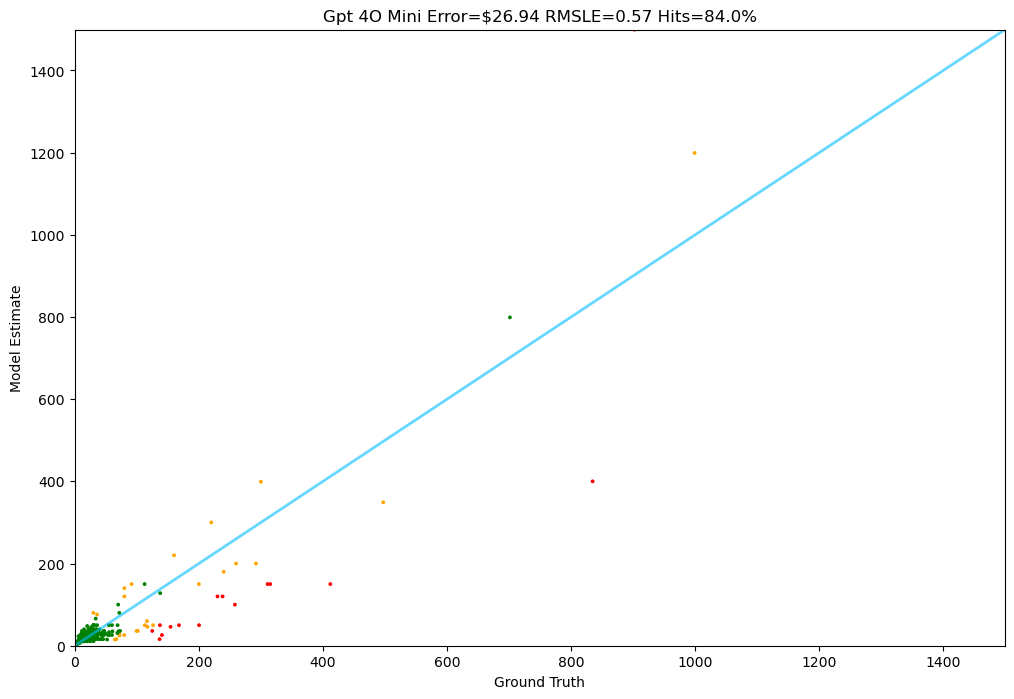

In [23]:
Tester.test(gpt_4o_mini, test)

In [24]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $66.47 Truth: $48.23 Error: $18.24 SLE: 0.10 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $25.00 Truth: $29.60 Error: $4.60 SLE: 0.03 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $32.99 Truth: $35.99 Error: $3.00 SLE: 0.01 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $15.99 Truth: $9.27 Error: $6.72 SLE: 0.25 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $32.99 Truth: $21.99 Error: $11.00 SLE: 0.15 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $47.00 Truth: $33.71 Error: $13.29 SLE: 0.11 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $30.00 Truth: $18.99 Error: $11.01 SLE: 0.19 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $25.99 Truth: $29.99 Error: $4.00 SLE: 0.02 Item: 5pcs Upgraded Wb03x24818 Gas Stove Knobs...
9: Guess: $13.99 Truth: $33.00 Error: $19.01 SLE: 0.67 Item: Gfhrisyty 350ML Milk Frothing Pitcher wi...
10: Guess: $30.00 Truth: $19.99 Error: $10.01 SLE: 0.15 Item

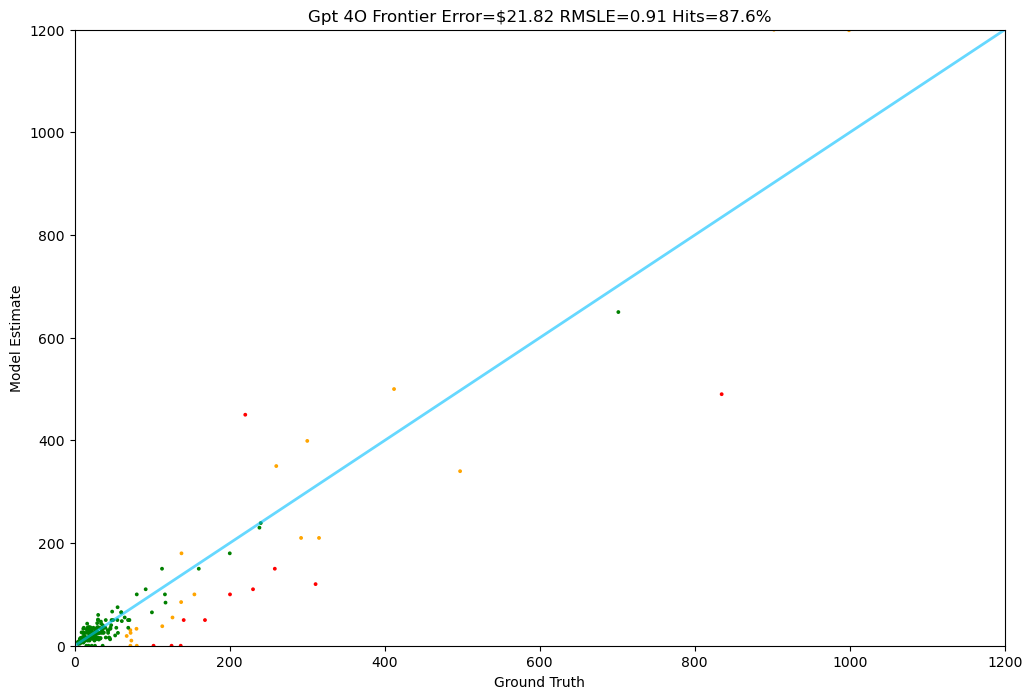

In [25]:
Tester.test(gpt_4o_frontier, test)

In [26]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $49.99 Truth: $48.23 Error: $1.76 SLE: 0.00 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $39.99 Truth: $29.60 Error: $10.39 SLE: 0.09 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $39.99 Truth: $35.99 Error: $4.00 SLE: 0.01 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $12.99 Truth: $9.27 Error: $3.72 SLE: 0.10 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $18.99 Truth: $21.99 Error: $3.00 SLE: 0.02 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $39.99 Truth: $33.71 Error: $6.28 SLE: 0.03 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $29.99 Truth: $18.99 Error: $11.00 SLE: 0.19 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $29.99 Truth: $29.99 Error: $0.00 SLE: 0.00 Item: 5pcs Upgraded Wb03x24818 Gas Stove Knobs...
9: Guess: $12.99 Truth: $33.00 Error: $20.01 SLE: 0.79 Item: Gfhrisyty 350ML Milk Frothing Pitcher wi...
10: Guess: $24.99 Truth: $19.99 Error: $5.00 SLE: 0.05 Item: D

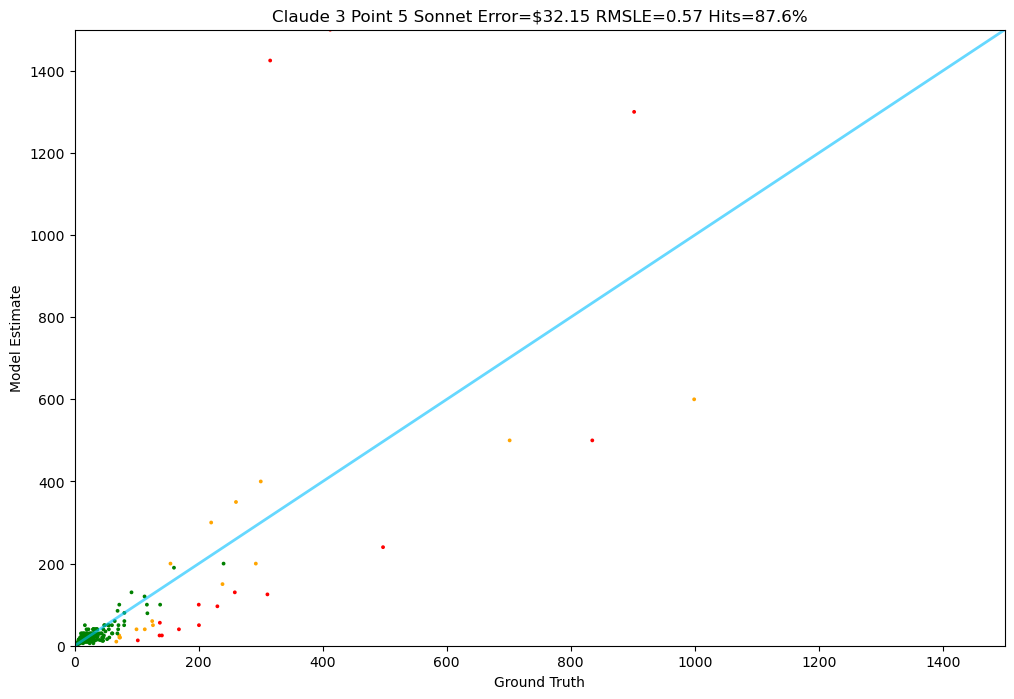

In [27]:
Tester.test(claude_3_point_5_sonnet, test)

In [30]:
fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

In [31]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [32]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil'},
 {'role': 'assistant', 'content': 'Price is $11.99'}]

In [33]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [34]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nand Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)\nContents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil"}, {"role": "assistant", "content": "Price is $11.99"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {

In [35]:
def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [36]:
write_jsonl(fine_tune_train, "fine_tune_train_lite.jsonl")

In [37]:
write_jsonl(fine_tune_validation, "fine_tune_validation_lite.jsonl")

In [39]:
with open("fine_tune_train_lite.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

with open("fine_tune_validation_lite.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")


In [40]:
train_file

FileObject(id='file-R4aaLf2yDHCPU1MLiRYXjz', bytes=194105, created_at=1757789470, filename='fine_tune_train_lite.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [41]:
validation_file

FileObject(id='file-AKirBNmbppqYVyfUGYggEd', bytes=48121, created_at=1757789471, filename='fine_tune_validation_lite.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [54]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [ ]:
# import wandb
# # Initialize W&B
# wandb.init(project="gpt-pricer", name="fine-tune-experiment")

# # Log your training parameters
# wandb.config.update({
#     "model": "gpt-4o-mini-2024-07-18",
#     "training_examples": len(fine_tune_train),
#     "validation_examples": len(fine_tune_validation),
#     "epochs": 1
# })

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:


Abort: 

In [43]:
train_file.id

'file-R4aaLf2yDHCPU1MLiRYXjz'

In [44]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-jDvKPCm1t4QkdSYEmq8zLz9n', created_at=1757789806, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-TyGQMoPBCL62gU6e1ZTuyoRq', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-R4aaLf2yDHCPU1MLiRYXjz', validation_file='file-AKirBNmbppqYVyfUGYggEd', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-jDvKPCm1t4QkdSYEmq8zLz9n'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='price

In [45]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-jDvKPCm1t4QkdSYEmq8zLz9n', created_at=1757789806, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-TyGQMoPBCL62gU6e1ZTuyoRq', result_files=[], seed=42, status='running', trained_tokens=None, training_file='file-R4aaLf2yDHCPU1MLiRYXjz', validation_file='file-AKirBNmbppqYVyfUGYggEd', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-jDvKPCm1t4QkdSYEmq8zLz9n'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1))), user_provided_su

In [46]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [47]:
job_id

'ftjob-jDvKPCm1t4QkdSYEmq8zLz9n'

In [50]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-jYc7tYXShOJIppeImAiqmrfk', created_at=1757790120, level='info', message='Step 10/200: training loss=2.28, validation loss=0.60', object='fine_tuning.job.event', data={'step': 10, 'train_loss': 2.284311056137085, 'valid_loss': 0.6047048568725586, 'total_steps': 200, 'train_mean_token_accuracy': 0.5, 'valid_mean_token_accuracy': 0.875}, type='metrics'),
 FineTuningJobEvent(id='ftevent-3Auccme2wv7LeqXVveA3xz4E', created_at=1757790115, level='info', message='Step 9/200: training loss=2.58', object='fine_tuning.job.event', data={'step': 9, 'train_loss': 2.583434820175171, 'total_steps': 200, 'train_mean_token_accuracy': 0.375}, type='metrics'),
 FineTuningJobEvent(id='ftevent-EwMUoSrTQeNibY1ymcEMEf6M', created_at=1757790098, level='info', message='Step 8/200: training loss=3.07', object='fine_tuning.job.event', data={'step': 8, 'train_loss': 3.065145969390869, 'total_steps': 200, 'train_mean_token_accuracy': 0.375}, type='metrics'),
 FineTuningJobEvent(id='ft

In [55]:
job = openai.fine_tuning.jobs.retrieve(job_id)
print(f"Status: {job.status}")
print(f"Model: {job.fine_tuned_model}")

Status: succeeded
Model: ft:gpt-4o-mini-2024-07-18:personal:pricer:CFPsPGl0


In [59]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [60]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:CFPsPGl0'

In [61]:
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [62]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

48.23
22.5


In [63]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

LG Genuine OEM Pulsator Plate/Washplate Assembly for LG Washing Machines
This high quality OEM LG Noise Filter Assembly is manufactured to exact specifications with durable materials and will fit a variety of LG Washing Machine models. Offering security and reliability that your LG Washing Machine will function correctly and will not be damaged by fluctuating electrical currents. The LG Noise Filter cleans the electricity from the electrical power supply to prevent control board damage from power surges by filter the electricity as it passes through the Noise Filter. Please be aware that the electrical power should be disconnected from the Washing Machine prior to making replacement on the appliance. Compatible Models This LG is a genuine OEM (Original Equipment Manufacturer) part manufactured to exact specifications Replacement Pump Motor is for LG Washing Machines is also called the Drain Pump The LG helps to remove water from

Price is

1: Guess: $22.50 Truth: $48.23 Error: $25.73 SLE: 0.55 Item: LG 5845EA1003B Genuine OEM Pulsator Plat...
2: Guess: $29.60 Truth: $29.60 Error: $0.00 SLE: 0.00 Item: DOMETIC 2932520014 Light Assembly for 6/...
3: Guess: $35.99 Truth: $35.99 Error: $0.00 SLE: 0.00 Item: S-Union Upgraded 4 Pack WB30M1 WB30M2 El...
4: Guess: $5.66 Truth: $9.27 Error: $3.61 SLE: 0.19 Item: BlueStars Ultra Durable 8565925 Dish Rac...
5: Guess: $21.99 Truth: $21.99 Error: $0.00 SLE: 0.00 Item: White Plaid Buffalo Farmhouse Dishwasher...
6: Guess: $33.71 Truth: $33.71 Error: $0.00 SLE: 0.00 Item: Vollrath (TR3) 19-3/4" x 19-3/4" Peg Rac...
7: Guess: $18.99 Truth: $18.99 Error: $0.00 SLE: 0.00 Item: Supplying Demand 11-293 Pilot Burner 5 F...
8: Guess: $47.99 Truth: $29.99 Error: $18.00 SLE: 0.21 Item: 5pcs Upgraded Wb03x24818 Gas Stove Knobs...
9: Guess: $22.99 Truth: $33.00 Error: $10.01 SLE: 0.12 Item: Gfhrisyty 350ML Milk Frothing Pitcher wi...
10: Guess: $18.99 Truth: $19.99 Error: $1.00 SLE: 0.00 Item: DC

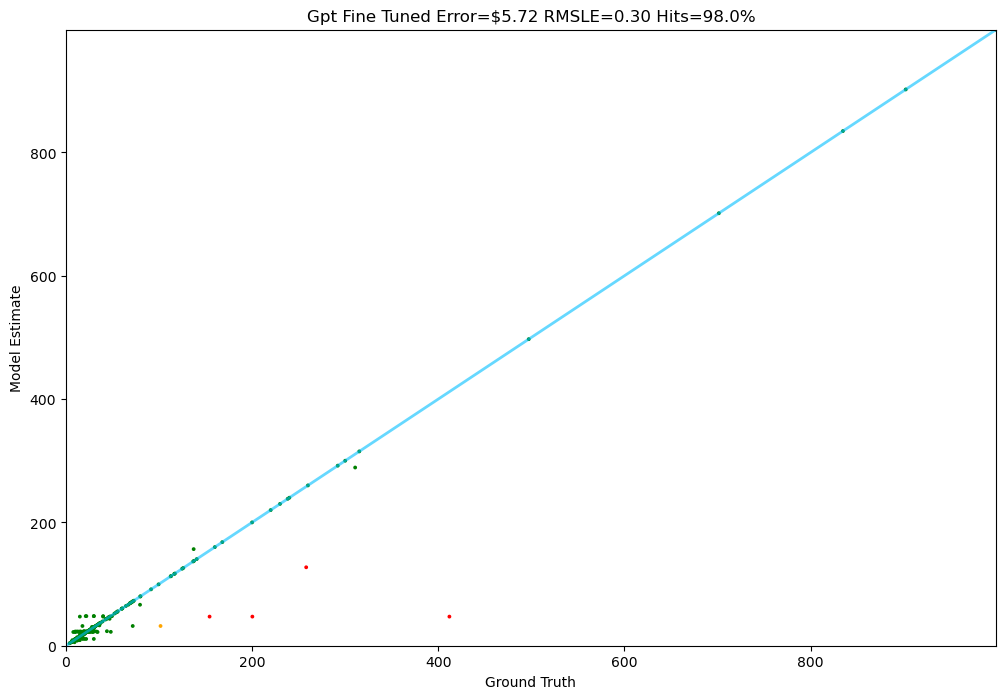

In [64]:
Tester.test(gpt_fine_tuned, test)